In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# 1. Load data from Excel (or CSV)
df = pd.read_csv("/Users/marclambertes/Python/Matches/Men/2024-2025/Scotland 2024-2025/Rangers 4-0 Ross County.csv")

# Extract the relevant columns containing qualifierId (for 'endX', 'endY', 'Corner', 'FK', 'ThrowIn')
type_cols = [col for col in df.columns if '/qualifierId' in col]

# Initialize new columns for 'endX' and 'endY'
df['endX'] = 0.0
df['endY'] = 0.0
# Populate 'endX' and 'endY' based on 'qualifierId'
for i in range(len(df)):
    df1 = df.iloc[i:i+1,:]
    j = 0
    for j in range(len(type_cols)):
        col = df1[type_cols[j]].values[0]
        if col == 140:
            endx = df1.loc[:,'qualifier/%i/value' %j].values[0]
            df.at[i, 'endX'] = endx
        else:
            j += 1
    k = 0
    for k in range(len(type_cols)):
        col = df1[type_cols[k]].values[0]
        if col == 141:
            endy = df1.loc[:,'qualifier/%i/value' %k].values[0]
            df.at[i, 'endY'] = endy
        else:
            k += 1

# Initialize new columns for 'Corner', 'FK', and 'ThrowIn'
df['Corner'] = 0
df['FK'] = 0
df['ThrowIn'] = 0
# Assign values based on conditions for 'Corner', 'FK', and 'ThrowIn'
for i in range(len(df)):
    df1 = df.iloc[i:i+1,:]
    for j in range(len(type_cols)):
        col = df1[type_cols[j]].values[0]
        if col == 6:
            df.at[i, 'Corner'] = 1
        if col == 5:
            df.at[i, 'FK'] = 1
        if col == 107:
            df.at[i, 'ThrowIn'] = 1

df['Assist'] = 0
for i in range(len(df)):
    df1 = df.iloc[i:i+1,:]
    for j in range(len(type_cols)):
        col = df1[type_cols[j]].values[0]
        if col == 210:
            df.at[i, 'Assist'] = 1

df['2nd Assist'] = 0
for i in range(len(df)):
    df1 = df.iloc[i:i+1,:]
    for j in range(len(type_cols)):
        col = df1[type_cols[j]].values[0]
        if col == 218:
            df.at[i, '2nd Assist'] = 1

# 2. Exclude rows where 'Corner', 'FK', or 'ThrowIn' == 1
df = df[~((df["Corner"] == 1) | (df["FK"] == 1) | (df["ThrowIn"] == 1))]

# 3. Ensure 'endX' and 'endY' are numeric (convert non-numeric to NaN and handle missing values)
df['endX'] = pd.to_numeric(df['endX'], errors='coerce')
df['endY'] = pd.to_numeric(df['endY'], errors='coerce')

# Fill NaN values with 0 (or any other strategy you prefer)
df['endX'].fillna(0, inplace=True)
df['endY'].fillna(0, inplace=True)

# 4. Calculate additional features (distance and angle)
df["distance_to_goal"] = np.sqrt((105 - df["endX"])**2 + (34 - df["endY"])**2)
df["angle_to_goal"] = np.arctan2(34 - df["endY"], 105 - df["endX"])

# 5. Encode the target variables
df["goal"] = (df["typeId"] == 16).astype(int)
df["loss"] = (df["typeId"] == 9).astype(int)
df["possession_continuation"] = ((df["typeId"] == 1) & (df["outcome"] == 1)).astype(int)
df["TakeO"] = (df["typeId"] == 3).astype(int)
df["Shot"] = ((df["typeId"] == 13) | (df["typeId"] == 14) | (df["typeId"] == 15)).astype(int)
df["Tackle"] = ((df["typeId"] == 7) & (df["outcome"] == 1)).astype(int)
df["Ball_recovery"] = (df["typeId"] == 49).astype(int)
df["Assists"] = (df["Assist"] == 1).astype(int)
df["2nd_Assists"] = (df["2nd Assist"] == 1).astype(int)

# 6. Define features and targets
features = [
    "x", "y", "endX", "endY", 
    "distance_to_goal", "angle_to_goal",
    "TakeO", "Shot", "Tackle", "Ball_recovery", 
    "Assists", "2nd_Assists"
]
targets = [
    "goal", "possession_continuation", "loss",
    "TakeO", "Shot", "Tackle", 
    "Ball_recovery", "Assists", "2nd_Assists"
]

# 7. Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[targets], test_size=0.2, random_state=42
)

# 8. Train RandomForest models for each outcome
models = {}
for target in targets:
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train[target])
    models[target] = clf

# 9. Predict probabilities using multiple simulations for stability
n_simulations = 1000
probs = {target: np.zeros(len(X_test)) for target in targets}

for _ in range(n_simulations):
    for target in targets:
        if len(models[target].classes_) == 1:
            probs[target] += 0
        else:
            probs[target] += models[target].predict_proba(X_test[features])[:, 1]

# 10. Average the probabilities over the simulations
for target in targets:
    probs[target] /= n_simulations
    X_test[f"{target}_prob"] = probs[target]

# 11. Define weights for each metric's contribution to EPV
weights = {
    "goal_prob": 1.5,
    "loss_prob": -1.0,
    "possession_continuation_prob": 0.8,
    "TakeO_prob": 0.5,
    "Shot_prob": 1.2,
    "Tackle_prob": 0.4,
    "Ball_recovery_prob": 0.6,
    "Assists_prob": 1.0,
    "2nd_Assists_prob": 0.7
}

# 12. Calculate a weighted EPV (before action)
X_test["epv_before"] = sum(
    weights[f"{target}_prob"] * X_test[f"{target}_prob"]
    for target in targets
)

# Simulate what happens after the action by modifying 'endX', 'endY' to predict next state's EPV
X_test_simulated = X_test.copy()
X_test_simulated["x"] = X_test_simulated["endX"]
X_test_simulated["y"] = X_test_simulated["endY"]

# Predict new probabilities for the simulated state
for target in targets:
    if len(models[target].classes_) == 1:
        X_test_simulated[f"{target}_prob_after"] = 0
    else:
        X_test_simulated[f"{target}_prob_after"] = models[target].predict_proba(X_test_simulated[features])[:, 1]

# Calculate epv_after from simulated probabilities
X_test["epv_after"] = sum(
    weights[f"{target}_prob"] * X_test_simulated[f"{target}_prob_after"]
    for target in targets
)

# 14. Calculate VAEP (Value Added by Expected Possession)
X_test["vaep"] = X_test["epv_after"] - X_test["epv_before"]

# 15. Merge the EPV and VAEP back into df
for target in targets:
    df[f"{target}_prob"] = np.nan
df["epv"] = np.nan
df["vaep"] = np.nan

df.loc[X_test.index, "epv"] = X_test["epv_after"]
df.loc[X_test.index, "vaep"] = X_test["vaep"]
for target in targets:
    df.loc[X_test.index, f"{target}_prob"] = X_test[f"{target}_prob"]

# 16. Calculate totals per player for all actions
totals_per_player = df.groupby("playerName")[
    ["goal", "loss", "possession_continuation", "TakeO", "Shot", "Tackle", "Ball_recovery", "Assists", "2nd_Assists"]
].sum().reset_index()

# Add EPV and VAEP totals
epv_vaep_per_player = df.groupby("playerName")["epv", "vaep"].sum().reset_index()

# Merge totals with probabilities, EPV, and VAEP
merged_df = pd.merge(totals_per_player, epv_vaep_per_player, on="playerName", how="left")

# 18. Save everything to a single Excel file
totals_filename = "AllPlayers_Totals_Probabilities_and_EPV_VAEP.xlsx"
merged_df.to_excel(totals_filename, index=False)

print(f"Saved total probabilities, EPV, and VAEP for all players to '{totals_filename}'. Here is a preview:")
print(merged_df.head())


Saved total probabilities, EPV, and VAEP for all players to 'AllPlayers_Totals_Probabilities_and_EPV_VAEP.xlsx'. Here is a preview:
   playerName  goal  loss  possession_continuation  TakeO  Shot  Tackle  \
0  A. MacLeod     0     0                        2      0     0       0   
1   A. Wright     0     0                       21      0     1       0   
2     B. Rice     0     0                       23      0     2       0   
3  C. Dessers     0     0                       11      1     6       1   
4   C. Nsiala     0     0                       72      1     0       1   

   Ball_recovery  Assists  2nd_Assists    epv   vaep  
0              2        0            0  0.000  0.000  
1              2        0            0  2.882  0.028  
2              2        0            0  4.214 -0.247  
3              1        2            0  5.338 -0.466  
4              1        2            0  9.108  0.572  


/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_41283/3293870498.py:191: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  epv_vaep_per_player = df.groupby("playerName")["epv", "vaep"].sum().reset_index()


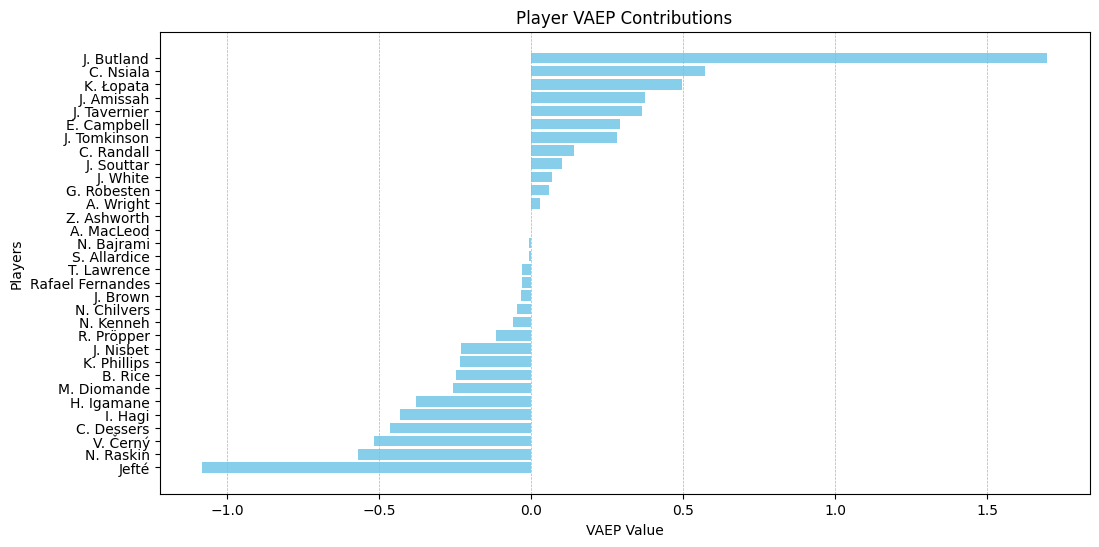

In [11]:
import matplotlib.pyplot as plt

# Group VAEP per player and plot
epv_vaep_per_player = df.groupby("playerName")["vaep"].sum().reset_index()

# Sort players by VAEP for better visualization
epv_vaep_per_player.sort_values(by="vaep", ascending=True, inplace=True)

# Bar Plot
plt.figure(figsize=(12, 6))
plt.barh(epv_vaep_per_player["playerName"], epv_vaep_per_player["vaep"], color="skyblue")
plt.title("Player VAEP Contributions")
plt.xlabel("VAEP Value")
plt.ylabel("Players")
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.show()